In [1]:
%matplotlib ipympl

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import matplotlib.patheffects as pe

import networkx as nx
import matplotlib.patches as mpatches

from learning.data.av2_utils import collate_av2_data, extract_input
from learning.data.process_utils import get_active_edges_mask
from matplotlib.colors import LinearSegmentedColormap
from learning.model.actionvalue_v2 import ActionValueModelV2
from learning.data.av2_dataset import ActionValueV2Dataset
from learning.data.load_utils import load_dicewars_data
import torch
import random

In [2]:
model_state = None
latest_epoch = -1

model_name = "actionvalue_v2_no_freeze"
models_dir = f"learning/{model_name}_checkpoints" 

# Find the latest checkpoint file (with highest epoch number)
checkpoint_files = glob.glob(os.path.join(models_dir, f"{model_name}_*.pt"))
# Extract epoch numbers from filenames
epoch_nums = [int(f.split("_")[-1].split(".")[0]) for f in checkpoint_files]
latest_epoch = max(epoch_nums)
latest_checkpoint = os.path.join(models_dir, f"{model_name}_{latest_epoch:06}.pt")
print(f"Loading latest checkpoint: {latest_checkpoint} (epoch {latest_epoch})")
checkpoint = torch.load(latest_checkpoint, map_location=torch.device('cpu'))
model_state = checkpoint["model_state"]

action_value_model = ActionValueModelV2()
action_value_model.load_state_dict(model_state)

Loading latest checkpoint: learning/actionvalue_v2_no_freeze_checkpoints/actionvalue_v2_no_freeze_000165.pt (epoch 165)


<All keys matched successfully>

In [3]:
history_folder = "server/history/"

history_files = sorted(glob.glob(os.path.join(history_folder, "history_*.json")))
history_file = history_files[random.randint(0, len(history_files))]
history_file = "server/history/history_00138_20250723_152743.json"
history_data = json.load(open(history_file, "r"))
print(history_file)

server/history/history_00138_20250723_152743.json


In [4]:
graph = nx.from_numpy_array(np.array(history_data["adjacency"]))

In [5]:
edges = np.array(graph.edges())

In [6]:
action_value_model

ActionValueModelV2(
  (gat_layers): ModuleList(
    (0): GATLayer(
      (message_heads): ModuleList(
        (0-1): 2 x GATMessage(
          (input_dropout): Dropout(p=0, inplace=False)
          (transform_fn): Linear(in_features=19, out_features=20, bias=False)
        )
      )
      (attention_coef_heads): ModuleList(
        (0-1): 2 x GATAttentionCoefficients(
          (transform_fn): Linear(in_features=40, out_features=1, bias=False)
          (activation_fn): LeakyReLU(negative_slope=0.01)
        )
      )
      (attention_dropout): Dropout(p=0.35, inplace=False)
      (activation_fn): ReLU()
      (in_states_pass): Linear(in_features=19, out_features=40, bias=False)
      (residual_dropout): Dropout(p=0.35, inplace=False)
    )
    (1-2): 2 x GATLayer(
      (message_heads): ModuleList(
        (0-1): 2 x GATMessage(
          (input_dropout): Dropout(p=0.35, inplace=False)
          (transform_fn): Linear(in_features=40, out_features=20, bias=False)
        )
      )
    

In [7]:
players_color_map = { 
    i: color for i, color in enumerate([
        "#b37ffe",  # purple
        "#b3ff01",  # lime green
        "#009302",  # dark green
        "#ff7ffe",  # pink
        "#ff7f01",  # orange
        "#b3fffe",  # light cyan
        "#ffff01",  # yellow
        "#ff5858"   # light red
    ])    
}

In [31]:
def draw_prediction(ax, graph, pos, history_data, index, model, colorbar_ax=None):
    data = ActionValueV2Dataset(json_data=load_dicewars_data(
        json_data=history_data, drop_terminal_state=True)
    )[index]
    
    in_data = collate_av2_data([data])
    inv_reindex = torch.argsort(data["reindex"])
    edges_tn = in_data["all_edges"]
    state_tn = in_data["nodes_states"]
    model.eval()
    with torch.no_grad():
        out = model(
            in_data["nodes_states"], 
            in_data["all_edges"], 
            in_data["node_graph_ids"], 
            in_data["edge_graph_ids"]
        )

    out_dict = out[0]
    end_turn_val = model.denormalize_output(out_dict["end_turn_val"]).numpy()
    edge_attack_val = model.denormalize_output(out_dict["edge_attack_val"]).numpy()

    # Create a custom blue-to-red colormap without white in the middle
    blue_red_cmap = LinearSegmentedColormap.from_list('BlueRed', ['red', 'yellow', 'green'])
    all_values = np.concatenate([end_turn_val[np.newaxis], edge_attack_val])
    vmax = all_values.max()
    vmin = all_values.min()

    # title color scale is 0-1 to highlight cases high probability for attack along any edge
    # edges color scale is 0-max_action_p to highlight with red which particular edge of attack is likely to be launched,
    #  if any - as eng of turn probability is included in the action max

    # Set the title with normal black text
    ax.set_title("Next action prediction")
    
    legend_start = (0.01, 0.93)
    patch_size = 0.05
    # Add a colored patch to show the probability visually in the top left
    patch = mpatches.Rectangle(
        legend_start,
        patch_size,
        patch_size, 
        transform=ax.transAxes,
        color=blue_red_cmap((end_turn_val - vmin) / (vmax - vmin)),
        edgecolor='black'
    )
    ax.add_patch(patch)
    ax.text(
        legend_start[0] + patch_size + 0.01, legend_start[1] + 0.02,  
        f"end_turn_v = {end_turn_val:.1f}", transform=ax.transAxes
    )

    # a bunch of embedding data is saved in first columns, player dice data is the last 8
    active_edges_mask = get_active_edges_mask(state_tn, edges_tn, active_player=-8)
    active_edges = edges_tn[:, active_edges_mask]
    flip_active_edges = active_edges[[1, 0], :]
    non_active_edges_mask = ~active_edges_mask
    
    # Create a mask for edges that are not flipped active edges
    # the shape of the equality comparison broadcasting is (2, E, A)
    non_flip_edges_mask = ~(edges_tn[:, :, torch.newaxis] == flip_active_edges[:, torch.newaxis, :]).all(0).any(-1)
    
    # we want to exclude all border edges from being added separately, not just active edges
    # while border edges from non-active player to active player are indeed non-active
    # they would overlap with active edges on a plot
    non_active_edges = edges_tn[:, non_active_edges_mask & non_flip_edges_mask].numpy()
    active_edges = active_edges.numpy()

    # Use a fixed curvature value for all edges
    nx.draw_networkx_edges(
        graph, pos,
        edgelist=active_edges.T,
        edge_color=edge_attack_val,
        edge_cmap=blue_red_cmap,
        edge_vmax=vmax,
        edge_vmin=vmin,
        width=2.0,  # Make edges thicker
        arrows=True,  # Add arrows to show direction
        arrowstyle="-|>",  # Use a nice arrow style
        ax=ax
    )
    nx.draw_networkx_edges(
        graph, pos,
        edgelist=non_active_edges.T,
        width=2,
        edge_color="grey",
        ax=ax
    )

    # Add edge labels with values
    edge_labels = {(u, v): f"{p:.0f}" for (u, v), p in zip(active_edges.T, edge_attack_val)}
    label_dict = nx.draw_networkx_edge_labels(
        graph, pos,
        edge_labels=edge_labels,
        font_size=8,
        font_color="black",
        font_weight="bold",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=0.1),
        label_pos=0.4,  # Position along the edge
        rotate=False,
        ax=ax
    )
    for k, lbl in label_dict.items():
        lbl.set_zorder(10)
        
    # Create a ScalarMappable for the colorbar if colorbar_ax is provided
    if colorbar_ax is not None:
        sm = plt.cm.ScalarMappable(cmap=blue_red_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        colorbar_ax.clear()
        colorbar = plt.colorbar(sm, cax=colorbar_ax, shrink=0.7, aspect=1)
        colorbar.set_label('Action Value Prediction')

In [32]:
def draw_state(ax_base, ax_pred, history_data, index, colorbar_ax=None):
    if index < len(history_data["actions"]):
        action = history_data["actions"][index]
    else:
        action = {"move_made": False, "turn_end": False, "player": None}

    state = history_data["states"][index]
    teams = np.array(state["teams"])
    dice = np.array(state["dice"])
    node_positions = history_data["node_positions"]

    pos = {
        i: np.array([1, -1]) * np.array(node_pos)
        for i, node_pos in enumerate(node_positions)
    }
    xs, ys = zip(*pos.values())            # list of all x and y after shift
    left_pad  = 7.0                        # blank space on the left
    pad = 3.0                        # default
    ax_base.set_xlim(min(xs) - left_pad,  max(xs) + pad)
    ax_base.set_ylim(min(ys) - pad,  max(ys) + pad)
    ax_pred.set_xlim(min(xs) - left_pad,  max(xs) + pad)
    ax_pred.set_ylim(min(ys) - pad,  max(ys) + pad)

    graph = nx.from_numpy_array(np.array(history_data["adjacency"]))

    # 1) Build unique list and assign colors
    unique_teams = sorted(set(teams))  # preserves order
    cmap = plt.get_cmap("Set3")
    # 8 teams max
    color_map = { 
        i: color for i, color in enumerate([
            "#b37ffe",  # purple
            "#b3ff01",  # lime green
            "#009302",  # dark green
            "#ff7ffe",  # pink
            "#ff7f01",  # orange
            "#b3fffe",  # light cyan
            "#ffff01",  # yellow
            "#ff5858"   # light red
        ])    
    }

    # 2) Draw nodes using that mapping
    node_colors = [ color_map[t] for t in teams ]
    nx.draw_networkx_nodes(
        graph, pos,
        node_size=300,
        node_color=node_colors,
        edgecolors='black',
        ax=ax_base
    )
    nx.draw_networkx_nodes(
        graph, pos,
        node_size=300,
        node_color=node_colors,
        edgecolors='black',
        ax=ax_pred
    )

    # 3) Draw edges & labels
    # ----------------------------------------------------------
    # 3a) draw ALL ordinary edges (no arrows, default styling)
    #     keep the special edge OUT of this list
    # ----------------------------------------------------------
    if action["move_made"]:
        special_edge = (action["from"], action["to"])  # <-- pick the edge (u, v)
        dice_in_attack = dice[action["from"]] - 1
    else:
        special_edge = None

    ordinary_edges = [e for e in graph.edges() if e != special_edge]

    nx.draw_networkx_edges(
        graph, pos,
        edgelist=ordinary_edges,
        width=2,
        edge_color="grey",
        ax=ax_base
    )

    if action["move_made"]:
        # ----------------------------------------------------------
        # 3b) draw THAT ONE edge again, but with a styled ARROW
        # ----------------------------------------------------------
        nx.draw_networkx_edges(
            graph, pos,
            edgelist=[special_edge],
            width=3,
            edge_color="darkblue",
            arrows=True,                 # activate arrowheads
            arrowstyle="-|>",            # filled triangular head
            arrowsize=10,                # head size (points)
            ax=ax_base
        )

        # ----------------------------------------------------------
        # 3c) add a text label on (or near) that edge
        # ----------------------------------------------------------
        edge_lbl = {special_edge: dice_in_attack}   # label text - number of dice used in attack
        nx.draw_networkx_edge_labels(
            graph, pos,
            edge_labels=edge_lbl,
            font_color="darkblue",
            font_weight="bold",
            font_size=11,
            label_pos=0.35,              # 0 = src node, 1 = dst node
            bbox=dict(facecolor="white", edgecolor="none", pad=0.1),
            ax=ax_base,
            rotate=False
        )


    # ----------------------------------------------------------
    # 3d) create node labels
    # ----------------------------------------------------------
    label_dict = { i: d for i, d in enumerate(dice) }
    nx.draw_networkx_labels(
        graph, pos,
        labels=label_dict,
        font_size=12,
        font_weight='bold',
        ax=ax_base
    )

    # 4) Build and add legend
    legend_handles = [
        mpatches.Patch(
            facecolor=color_map[team], label=str(team), 
            edgecolor="black", linewidth=1
        )
        for team in unique_teams
    ]
    ax_base.legend(
        handles=legend_handles,
        title="Player",
        loc='upper left',      # Position the legend at the upper left
    )

    # 5) Add action description title
    title = f"State #{index} / {len(history_data['states']) - 1}"
    title += f"\nPlayer {action['player']}"

    if action["move_made"]:
        title = title \
            + f" attacked" \
            + f" from node {special_edge[0]} to {special_edge[1]}" \
            + f" with {dice_in_attack} dice"
    if action["turn_end"]:
        title += " ended the turn"

    ax_base.set_title(title, fontsize=16)

    # 6) Finalize
    #ax_base.axis('off')
    #ax_pred.axis('off')
    ax_base.format_coord = lambda x, y: ""      # suppress the live x-, y-readout
    ax_pred.format_coord = lambda x, y: ""     

    draw_prediction(ax_pred, graph, pos, history_data, index, action_value_model, colorbar_ax=colorbar_ax)

/tmp/ipykernel_3189887/2081614673.py:39: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = mpatches.Rectangle(


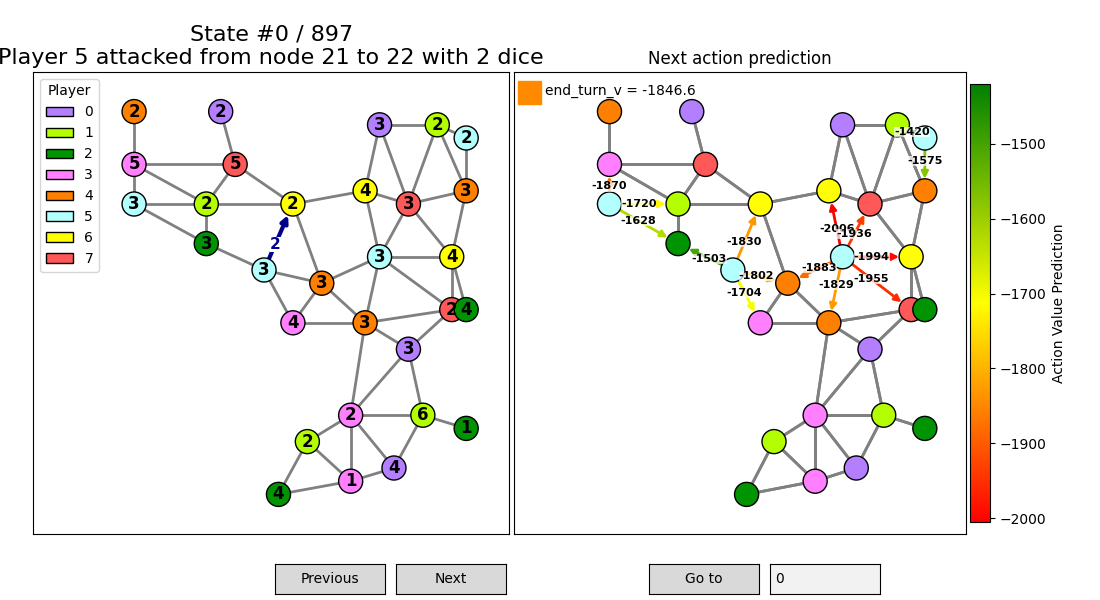

In [33]:
from matplotlib.widgets import Button, TextBox
from matplotlib.gridspec import GridSpec
from matplotlib.figure import SubplotParams

plt.close('all')

# Create figure with GridSpec for flexible layout
# Inject subplot parameters directly in figure creation
fig = plt.figure(figsize=(11, 6), 
                 subplotpars=SubplotParams(left=0.03, right=0.90))
gs = GridSpec(40, 40, figure=fig)  # Added wspace parameter to reduce horizontal spacing

# Create axes: main plot, prediction plot, and colorbar
real_ax = fig.add_subplot(gs[:, :20])  # First 20 columns
predicted_ax = fig.add_subplot(gs[:, 20:-1])  # Next columns except last
colorbar_ax = fig.add_subplot(gs[1:-1, -1:])  # Last column for colorbar

n_states = len(history_data["states"])
# Initialize with the first state
current_idx = 0
max_idx = len(history_data["states"]) - 1

# Function to update the plot
def update_plot(idx):
    real_ax.clear()
    predicted_ax.clear()
    draw_state(real_ax, predicted_ax, history_data, idx, colorbar_ax)
    text_box.set_val(str(idx))
    plt.draw()

# Initial plot
draw_state(real_ax, predicted_ax, history_data, current_idx, colorbar_ax)

# Add buttons for navigation and text input
prev_ax = plt.axes([0.25, 0.01, 0.1, 0.05])
next_ax = plt.axes([0.36, 0.01, 0.1, 0.05])  # Centered next button
go_ax = plt.axes([0.59, 0.01, 0.1, 0.05])
text_ax = plt.axes([0.7, 0.01, 0.1, 0.05])


# Create the text input for state index
text_box = TextBox(text_ax, label="", initial=str(current_idx))

# Go button handler
def go_click(event):
    global current_idx
    try:
        idx = int(text_box.text)
        # If the index is out of bounds, clamp it to valid range
        if idx < 0:
            current_idx = 0
        elif idx > max_idx:
            current_idx = max_idx
        else:
            current_idx = idx
    except ValueError:
        current_idx = 0

    text_box.set_val(str(current_idx))
    update_plot(current_idx)

go_button = Button(go_ax, 'Go to')
go_button.on_clicked(go_click)
prev_button = Button(prev_ax, 'Previous')
next_button = Button(next_ax, 'Next')

# Button click handlers
def prev_click(event):
    global current_idx
    current_idx = max(0, current_idx - 1)
    update_plot(current_idx)

def next_click(event):
    global current_idx
    current_idx = min(max_idx, current_idx + 1)
    update_plot(current_idx)

prev_button.on_clicked(prev_click)
next_button.on_clicked(next_click)

plt.show()

In [11]:
A = torch.tensor(history_data["adjacency"])

In [12]:
D = A.sum(dim=1, keepdim=True)

In [13]:
P = 1 / D * A

In [14]:
P

tensor([[0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.2500, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.0000, 0.0000, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000,
         0.1667, 0.0000, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.0000,
       

In [15]:
D ** -2

RuntimeError: Integers to negative integer powers are not allowed.

In [ ]:
L_sym =